In [31]:
import sqlite3
import pandas as pd

# Remplacez "ma_base_de_donnees.db" par le nom de votre base de données SQLite
nom_base_de_donnees = "ma_base_de_donnees.db"

# Colones que vous souhaitez récupérer
colonne1 = "Good_chords"
colonne2 = "notes"

# Initialisation d'un DataFrame vide
df = pd.DataFrame()

# Connexion à la base de données
connexion = sqlite3.connect(nom_base_de_donnees)

# Obtenez la liste des tables disponibles dans la base de données
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(tables_query, connexion)['name']

# Boucle à travers les tables et récupération des données
for nom_table in tables:
    requete_sql = f"SELECT {colonne1}, {colonne2} FROM \"{nom_table}\""
    table_df = pd.read_sql_query(requete_sql, connexion)
    
    # Fusionner le DataFrame actuel avec le DataFrame de la table courante
    df = pd.concat([df, table_df], ignore_index=True)

# Affichage du DataFrame combiné
print(df)

# Fermeture de la connexion
connexion.close()


     Good_chords                       notes
0             NM                         nan
1             EM            ['E', 'G#', 'B']
2             AM            ['A', 'C#', 'E']
3             EM            ['E', 'G#', 'B']
4             BM           ['B', 'D#', 'F#']
...          ...                         ...
1006          AM            ['A', 'C#', 'E']
1007          AM            ['A', 'C#', 'E']
1008          DM            ['D', 'F#', 'A']
1009          D9  ['D', 'F#', 'A', 'C', 'E']
1010          NM                         nan

[1011 rows x 2 columns]


In [32]:
df.head()

,Good_chords,notes
0,NM,nan
1,EM,"['E', 'G#', 'B']"
2,AM,"['A', 'C#', 'E']"
3,EM,"['E', 'G#', 'B']"
4,BM,"['B', 'D#', 'F#']"


In [33]:
import re
import tensorflow as tf

max_features = 4000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['notes'].values)
X = tokenizer.texts_to_sequences(df['notes'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X) 

In [34]:
X[1]

array([0, 0, 0, 0, 0, 2, 9, 1, 3])

In [35]:
X.shape

(1011, 9)

In [36]:
import numpy as np
nb_classe = len(np.unique(df['Good_chords']))

In [37]:
classes = np.unique(df['Good_chords'])

In [38]:
embed_dim = 300
lstm_out = 196

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(tf.keras.layers.SpatialDropout1D(0.4))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, dropout=0.05, recurrent_dropout=0.2)))
model.add(tf.keras.layers.Dense(nb_classe, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 9, 300)            1200000   
                                                                 
 spatial_dropout1d_2 (Spati  (None, 9, 300)            0         
 alDropout1D)                                                    
                                                                 
 bidirectional_2 (Bidirecti  (None, 392)               779296    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 45)                17685     
                                                                 
Total params: 1996981 (7.62 MB)
Trainable params: 1996981 (7.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
from sklearn.model_selection import train_test_split
import numpy as np
Y = pd.get_dummies(df['Good_chords'])
Y.head()

,A7,AM,Amaj7,Amaj7/E,Amin,Amin/C,B7,BM,Bb7,BbM,...,F#min7,F#minmaj7,F9,FM,G#M,G#min,G#min7,GM,Gmin,NM
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [40]:
Y = Y.values

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(677, 9) (677, 45)
(334, 9) (334, 45)


In [42]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, verbose=2,validation_split=0.3)

Epoch 1/20
4/4 - 9s - loss: 3.7462 - accuracy: 0.2051 - val_loss: 3.6118 - val_accuracy: 0.3284 - 9s/epoch - 2s/step
Epoch 2/20
4/4 - 1s - loss: 3.4878 - accuracy: 0.3087 - val_loss: 3.2015 - val_accuracy: 0.1225 - 627ms/epoch - 157ms/step
Epoch 3/20
4/4 - 1s - loss: 2.9612 - accuracy: 0.1501 - val_loss: 2.9244 - val_accuracy: 0.1225 - 650ms/epoch - 162ms/step
Epoch 4/20
4/4 - 1s - loss: 2.7869 - accuracy: 0.2178 - val_loss: 2.7515 - val_accuracy: 0.1765 - 620ms/epoch - 155ms/step
Epoch 5/20
4/4 - 1s - loss: 2.5691 - accuracy: 0.4440 - val_loss: 2.5673 - val_accuracy: 0.3873 - 623ms/epoch - 156ms/step
Epoch 6/20
4/4 - 1s - loss: 2.4045 - accuracy: 0.4503 - val_loss: 2.3478 - val_accuracy: 0.5441 - 620ms/epoch - 155ms/step
Epoch 7/20
4/4 - 1s - loss: 2.1357 - accuracy: 0.5624 - val_loss: 2.0357 - val_accuracy: 0.5441 - 631ms/epoch - 158ms/step
Epoch 8/20
4/4 - 1s - loss: 1.8004 - accuracy: 0.5751 - val_loss: 1.7277 - val_accuracy: 0.6029 - 630ms/epoch - 157ms/step
Epoch 9/20
4/4 - 1s - 

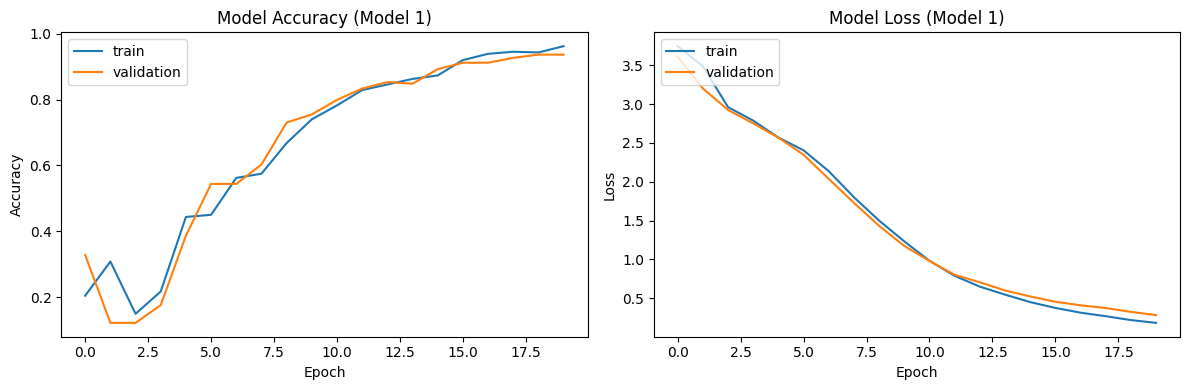

In [43]:
import matplotlib.pyplot as plt


# Créez une figure avec une grille de sous-graphiques 1x2
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Ajustez la taille de la figure selon vos besoins

# Premier sous-graphique (précisez le nombre d'époques dans 'range(len(history1['accuracy']))')
axs[0].plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='train')
axs[0].plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='validation')
axs[0].set_title('Model Accuracy (Model 1)')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='upper left')

axs[1].plot(range(len(history.history['loss'])), history.history['loss'], label='train')
axs[1].plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='validation')
axs[1].set_title('Model Loss (Model 1)')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper left')

# Ajustez l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichez la figure
plt.show()


In [44]:
score, acc = model.evaluate(X_test, Y_test, verbose=2, batch_size=64)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

6/6 - 0s - loss: 0.4694 - accuracy: 0.9341 - 163ms/epoch - 27ms/step
score: 0.47
acc: 0.93


In [45]:
import numpy as np

# Supposons que vous avez plusieurs séquences dans twt
twt = ["['B', 'D#', 'F#']", "['C', 'E', 'G']", "['A', 'C#', 'E']"]

# Convertissez les séquences en représentations numériques
twt_sequences = tokenizer.texts_to_sequences(twt)

# Remplacez les valeurs manquantes par des zéros
twt_padded = tf.keras.preprocessing.sequence.pad_sequences(twt_sequences, maxlen=X.shape[1], dtype='int32', value=0)

# Effectuez la prédiction avec votre modèle
predictions = model.predict(twt_padded, batch_size=len(twt))


# Affichez les résultats pour chaque séquence
for i, prediction in enumerate(predictions):
    predicted_class_index = np.argmax(prediction)
    predicted_class = classes[predicted_class_index]
    print(f"Séquence {i+1} - Classe prédite : {predicted_class}")


1/1 [==============================] - 1s 1s/step
Séquence 1 - Classe prédite : BM
Séquence 2 - Classe prédite : CM
Séquence 3 - Classe prédite : AM
